<a href="https://colab.research.google.com/github/zhrldnpftl/DKU-Capstone-DeepPhish/blob/main/Deepvoice-Detection/0.%20preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 패키지 설치 및 기본 환경 구성

In [ ]:
# Google Colab 환경에서 필요한 패키지 설치
!pip install datasets torchaudio kagglehub
# Hugging Face datasets, 오디오 처리용 torchaudio, kagglehub

# 라이브러리 import
import os                                    # 경로 조작용
import kagglehub                             # KaggleHub를 통해 kagglehub dataset 다운로드
from datasets import load_dataset, Audio     # HuggingFace datasets API 및 오디오 타입
import torch                                 # PyTorch - 텐서 처리
import torchaudio                            # 오디오 처리용 torchaudio
import torchaudio.transforms as T            # torchaudio에서 제공하는 오디오 변환 함수들
import numpy as np                           # 넘파이 배열 연산
import matplotlib.pyplot as plt              # 시각화 도구
import glob                                  # 파일 탐색용
from google.colab import drive               # Google Drive 연동
from itertools import islice
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 2. Google Drive 연동 및 저장 경로 설정

In [ ]:
# Google Drive를 마운트 (연결)
drive.mount('/content/drive')  # 브라우저에 인증 링크 제공

# 전처리 결과 저장 경로 설정
save_dir = "/content/drive/MyDrive/Capstone"  # Google Drive 내 Capstone 폴더 경로
os.makedirs(save_dir, exist_ok=True)          # 폴더가 없으면 생성

# label_0, label_1 하위 폴더 경로 정의
label0_dir = os.path.join(save_dir, "label_0")
label1_dir = os.path.join(save_dir, "label_1")

# 폴더가 없다면 생성
os.makedirs(label0_dir, exist_ok=True)
os.makedirs(label1_dir, exist_ok=True)



Mounted at /content/drive


# 3. 전처리 설정 및 함수 정의

In [ ]:
# 전처리용 파라미터 정의
SAMPLE_RATE = 16000           # 모든 오디오를 16kHz로 맞춤
N_MELS = 80                   # Mel-spectrogram에서 사용할 Mel 밴드 수
MAX_DURATION = 3              # 최대 허용 오디오 길이 (초)
HOP_LENGTH = 160              # Mel-spectrogram 프레임 간 간격
MAX_FRAMES = int((SAMPLE_RATE / HOP_LENGTH) * MAX_DURATION)  # 3초 기준 최대 프레임 수
# Mel-spectrogram 변환기 정의
mel_transform = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,  # 목표 샘플레이트
    n_fft=400,                # FFT 크기
    hop_length=HOP_LENGTH,    # 프레임 간 이동 간격
    n_mels=N_MELS             # Mel 밴드 수
)

# Amplitude를 로그 스케일로 변환 (dB)
amplitude_to_db = T.AmplitudeToDB()
# 오디오 전처리 함수 정의
def preprocess_audio(waveform, sample_rate):

    waveform = waveform.to(torch.float32)  # float64 → float32 변환
    # 샘플레이트가 16kHz가 아니면 리샘플링
    if sample_rate != SAMPLE_RATE:
        resampler = T.Resample(orig_freq=sample_rate, new_freq=SAMPLE_RATE)
        waveform = resampler(waveform)

    # stereo인 경우 → mono로 평균 처리
    if waveform.shape[0] == 2:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Mel-spectrogram 생성
    mel_spec = mel_transform(waveform)

    # 로그 스케일로 변환
    log_mel = amplitude_to_db(mel_spec).squeeze(0)

    # 시간 축 길이 고정 (패딩 or 잘라내기)
    if log_mel.shape[1] < MAX_FRAMES:
        log_mel = torch.nn.functional.pad(log_mel, (0, MAX_FRAMES - log_mel.shape[1]))
    else:
        log_mel = log_mel[:, :MAX_FRAMES]

    # numpy 배열로 반환
    return log_mel.numpy().astype(np.float32)


# 3.5. 코드가 중간에 중단되더라도 지속할 수 있는 함수 (사용 X)

In [ ]:
def resume_preprocessing_and_save(dataset, label_dir, label, sample_rate, preprocess_fn):
    """
    중단된 시점부터 전처리를 이어서 .npy로 저장하는 함수

    Args:
        dataset: Hugging Face StreamingDataset 객체
        label_dir: 저장 경로 (예: '/content/drive/MyDrive/Capstone/label_0')
        label: 정수형 라벨 (예: 0 또는 1)
        sample_rate: 전처리에 사용할 샘플링 레이트 (예: 16000)
        preprocess_fn: waveform과 샘플레이트를 받아 전처리된 feature를 반환하는 함수
    """
    os.makedirs(label_dir, exist_ok=True)  # 폴더 없으면 생성

    # ✅ 이미 저장된 파일 개수 확인
    existing_files = glob.glob(os.path.join(label_dir, "*.npy"))
    start_idx = len(existing_files)
    print(f"📁 라벨 {label}의 이미 저장된 파일 수: {start_idx}개 → 이어서 시작합니다.")

    # ✅ 데이터셋 스트리밍에서 중단된 지점부터 반복
    for idx, sample in enumerate(islice(dataset, start_idx, None), start=start_idx):
        try:
            # 오디오 waveform 가져오기 및 float32 변환
            waveform = torch.tensor(sample["audio"]["array"]).unsqueeze(0).to(torch.float32)

            # 전처리 함수 호출
            features = preprocess_fn(waveform, sample_rate)

            # 파일명 지정 및 저장
            save_path = os.path.join(label_dir, f"sample_{idx:05d}.npy")
            np.save(save_path, features)

            # 상태 출력
            if idx % 500 == 0:
                print(f"✅ 라벨 {label} 샘플 저장됨: {idx}개")
        except Exception as e:
            print(f"⚠️ 라벨 {label} 오류 (index {idx}): {e}")

def resume_fake_or_real(audio_file_list, label_dir, sample_rate, preprocess_fn):
    """
    중단된 시점부터 Fake or Real 오디오 파일 전처리하고 저장하는 함수

    Args:
        audio_file_list (list): .wav 파일 경로 리스트
        label_dir (str): 저장 경로 (예: "/content/drive/MyDrive/Capstone/label_1")
        sample_rate (int): 전처리에 사용할 샘플링 레이트
        preprocess_fn (function): 전처리 함수 (waveform, sample_rate) → log-mel 반환
    """
    os.makedirs(label_dir, exist_ok=True)

    # ✅ 이미 저장된 파일 개수 확인
    existing_files = glob.glob(os.path.join(label_dir, "*.npy"))
    start_idx = len(existing_files)
    print(f"📁 라벨 1: {start_idx}개 저장됨 → 이어서 {start_idx}번부터 처리 시작")

    # ✅ 남은 파일만 전처리
    for idx, path in enumerate(audio_file_list[start_idx:], start=start_idx):
        try:
            # 오디오 로드 및 float32 변환
            waveform, sr = torchaudio.load(path)
            waveform = waveform.to(torch.float32)

            # 전처리
            features = preprocess_fn(waveform, sr)

            # 저장
            save_path = os.path.join(label_dir, f"sample_{idx:05d}.npy")
            np.save(save_path, features)

            if idx % 200 == 0:
                print(f"✅ 라벨 1 샘플 저장됨: {idx}개")
        except Exception as e:
            print(f"⚠️ 오류 발생 (file: {path}): {e}")


# 4. People's Speech 데이터 전처리 (라벨 0)

In [ ]:

# HuggingFace에서 스트리밍 방식으로 clean dataset 로드
print(" People's Speech 데이터 전처리 중...")
people_ds = load_dataset("MLCommons/peoples_speech", "clean", split="train", streaming=True)

# 오디오 컬럼을 16kHz로 디코딩하도록 지정
people_ds = people_ds.cast_column("audio", Audio(sampling_rate=SAMPLE_RATE, decode=True))
# 스트리밍 데이터셋에서 하나씩 불러와 전처리 수행
for idx, sample in enumerate(people_ds):
    try:
        waveform = torch.tensor(sample["audio"]["array"]).unsqueeze(0)  # numpy → torch tensor
        features = preprocess_audio(waveform, SAMPLE_RATE)              # 전처리 수행

        # 저장
        np.save(os.path.join(label0_dir, f"sample_{idx:05d}.npy"), features)
        # 상태 출력
        if idx % 500 == 0:
            print(f" 정상 샘플 처리됨: {idx}개")

       # if idx == 1000: break
    except Exception as e:
        print(f"오류 발생 (index {idx}): {e}")

    # 테스트 목적: 일부 샘플만 처리할 경우 사용
    # if idx == 1000: break


🔄 People's Speech 데이터 전처리 중...


Resolving data files:   0%|          | 0/804 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/804 [00:00<?, ?it/s]

✅ 정상 샘플 처리됨: 0개
✅ 정상 샘플 처리됨: 500개
✅ 정상 샘플 처리됨: 1000개
✅ 정상 샘플 처리됨: 1500개
✅ 정상 샘플 처리됨: 2000개
✅ 정상 샘플 처리됨: 2500개
✅ 정상 샘플 처리됨: 3000개
✅ 정상 샘플 처리됨: 3500개
✅ 정상 샘플 처리됨: 4000개
✅ 정상 샘플 처리됨: 4500개
✅ 정상 샘플 처리됨: 5000개
✅ 정상 샘플 처리됨: 5500개
✅ 정상 샘플 처리됨: 6000개
✅ 정상 샘플 처리됨: 6500개
✅ 정상 샘플 처리됨: 7000개
✅ 정상 샘플 처리됨: 7500개
✅ 정상 샘플 처리됨: 8000개
✅ 정상 샘플 처리됨: 8500개
✅ 정상 샘플 처리됨: 9000개
✅ 정상 샘플 처리됨: 9500개
✅ 정상 샘플 처리됨: 10000개
✅ 정상 샘플 처리됨: 10500개
✅ 정상 샘플 처리됨: 11000개
✅ 정상 샘플 처리됨: 11500개
✅ 정상 샘플 처리됨: 12000개
✅ 정상 샘플 처리됨: 12500개
✅ 정상 샘플 처리됨: 13000개
✅ 정상 샘플 처리됨: 13500개
✅ 정상 샘플 처리됨: 14000개
✅ 정상 샘플 처리됨: 14500개
✅ 정상 샘플 처리됨: 15000개
✅ 정상 샘플 처리됨: 15500개
✅ 정상 샘플 처리됨: 16000개
✅ 정상 샘플 처리됨: 16500개
✅ 정상 샘플 처리됨: 17000개
✅ 정상 샘플 처리됨: 17500개
✅ 정상 샘플 처리됨: 18000개
✅ 정상 샘플 처리됨: 18500개
✅ 정상 샘플 처리됨: 19000개
✅ 정상 샘플 처리됨: 19500개
✅ 정상 샘플 처리됨: 20000개
✅ 정상 샘플 처리됨: 20500개
✅ 정상 샘플 처리됨: 21000개
✅ 정상 샘플 처리됨: 21500개
✅ 정상 샘플 처리됨: 22000개
✅ 정상 샘플 처리됨: 22500개
✅ 정상 샘플 처리됨: 23000개
✅ 정상 샘플 처리됨: 23500개
✅ 정상 샘플 처리됨: 24000개
✅ 정상 샘플 처리됨: 24500개
✅ 정상 샘플 처리됨: 25000개
✅ 정상

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 31854ee4-6241-4dc4-b823-b5727937c080)')' thrown while requesting GET https://huggingface.co/datasets/MLCommons/peoples_speech/resolve/f10597c5d3d3a63f8b6827701297c3afdf178272/clean/train-00089-of-00804.parquet
Retrying in 1s [Retry 1/5].


✅ 정상 샘플 처리됨: 167000개
✅ 정상 샘플 처리됨: 167500개
✅ 정상 샘플 처리됨: 168000개
✅ 정상 샘플 처리됨: 168500개
✅ 정상 샘플 처리됨: 169000개
✅ 정상 샘플 처리됨: 169500개
✅ 정상 샘플 처리됨: 170000개
✅ 정상 샘플 처리됨: 170500개
✅ 정상 샘플 처리됨: 171000개
✅ 정상 샘플 처리됨: 171500개
✅ 정상 샘플 처리됨: 172000개
✅ 정상 샘플 처리됨: 172500개
✅ 정상 샘플 처리됨: 173000개
✅ 정상 샘플 처리됨: 173500개
✅ 정상 샘플 처리됨: 174000개
✅ 정상 샘플 처리됨: 174500개
✅ 정상 샘플 처리됨: 175000개
✅ 정상 샘플 처리됨: 175500개
✅ 정상 샘플 처리됨: 176000개
✅ 정상 샘플 처리됨: 176500개
✅ 정상 샘플 처리됨: 177000개
✅ 정상 샘플 처리됨: 177500개
✅ 정상 샘플 처리됨: 178000개
✅ 정상 샘플 처리됨: 178500개
✅ 정상 샘플 처리됨: 179000개
✅ 정상 샘플 처리됨: 179500개
✅ 정상 샘플 처리됨: 180000개
✅ 정상 샘플 처리됨: 180500개
✅ 정상 샘플 처리됨: 181000개
✅ 정상 샘플 처리됨: 181500개
✅ 정상 샘플 처리됨: 182000개
✅ 정상 샘플 처리됨: 182500개
✅ 정상 샘플 처리됨: 183000개
✅ 정상 샘플 처리됨: 183500개
✅ 정상 샘플 처리됨: 184000개
✅ 정상 샘플 처리됨: 184500개
✅ 정상 샘플 처리됨: 185000개


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ec636d4e-0d14-49b5-9904-77c13af34d72)')' thrown while requesting GET https://huggingface.co/datasets/MLCommons/peoples_speech/resolve/f10597c5d3d3a63f8b6827701297c3afdf178272/clean/train-00099-of-00804.parquet
Retrying in 1s [Retry 1/5].


✅ 정상 샘플 처리됨: 185500개
✅ 정상 샘플 처리됨: 186000개
✅ 정상 샘플 처리됨: 186500개
✅ 정상 샘플 처리됨: 187000개
✅ 정상 샘플 처리됨: 187500개
✅ 정상 샘플 처리됨: 188000개
✅ 정상 샘플 처리됨: 188500개
✅ 정상 샘플 처리됨: 189000개
✅ 정상 샘플 처리됨: 189500개
✅ 정상 샘플 처리됨: 190000개
✅ 정상 샘플 처리됨: 190500개
✅ 정상 샘플 처리됨: 191000개
✅ 정상 샘플 처리됨: 191500개
✅ 정상 샘플 처리됨: 192000개
✅ 정상 샘플 처리됨: 192500개
✅ 정상 샘플 처리됨: 193000개
✅ 정상 샘플 처리됨: 193500개
✅ 정상 샘플 처리됨: 194000개
✅ 정상 샘플 처리됨: 194500개
✅ 정상 샘플 처리됨: 195000개
✅ 정상 샘플 처리됨: 195500개
✅ 정상 샘플 처리됨: 196000개
✅ 정상 샘플 처리됨: 196500개
✅ 정상 샘플 처리됨: 197000개
✅ 정상 샘플 처리됨: 197500개
✅ 정상 샘플 처리됨: 198000개
✅ 정상 샘플 처리됨: 198500개
✅ 정상 샘플 처리됨: 199000개
✅ 정상 샘플 처리됨: 199500개
✅ 정상 샘플 처리됨: 200000개
✅ 정상 샘플 처리됨: 200500개
✅ 정상 샘플 처리됨: 201000개
✅ 정상 샘플 처리됨: 201500개
✅ 정상 샘플 처리됨: 202000개
✅ 정상 샘플 처리됨: 202500개
✅ 정상 샘플 처리됨: 203000개
✅ 정상 샘플 처리됨: 203500개
✅ 정상 샘플 처리됨: 204000개
✅ 정상 샘플 처리됨: 204500개
✅ 정상 샘플 처리됨: 205000개
✅ 정상 샘플 처리됨: 205500개
✅ 정상 샘플 처리됨: 206000개
✅ 정상 샘플 처리됨: 206500개
✅ 정상 샘플 처리됨: 207000개
✅ 정상 샘플 처리됨: 207500개
✅ 정상 샘플 처리됨: 208000개
✅ 정상 샘플 처리됨: 208500개
✅ 정상 샘플 처리됨: 

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ce9d5e53-a960-458f-9750-204b1d3e4069)')' thrown while requesting GET https://huggingface.co/datasets/MLCommons/peoples_speech/resolve/f10597c5d3d3a63f8b6827701297c3afdf178272/clean/train-00215-of-00804.parquet
Retrying in 1s [Retry 1/5].


✅ 정상 샘플 처리됨: 402000개
✅ 정상 샘플 처리됨: 402500개
✅ 정상 샘플 처리됨: 403000개
✅ 정상 샘플 처리됨: 403500개
✅ 정상 샘플 처리됨: 404000개
✅ 정상 샘플 처리됨: 404500개
✅ 정상 샘플 처리됨: 405000개
✅ 정상 샘플 처리됨: 405500개
✅ 정상 샘플 처리됨: 406000개
✅ 정상 샘플 처리됨: 406500개
✅ 정상 샘플 처리됨: 407000개
✅ 정상 샘플 처리됨: 407500개
✅ 정상 샘플 처리됨: 408000개
✅ 정상 샘플 처리됨: 408500개
✅ 정상 샘플 처리됨: 409000개
✅ 정상 샘플 처리됨: 409500개
✅ 정상 샘플 처리됨: 410000개
✅ 정상 샘플 처리됨: 410500개
✅ 정상 샘플 처리됨: 411000개
✅ 정상 샘플 처리됨: 411500개
✅ 정상 샘플 처리됨: 412000개
✅ 정상 샘플 처리됨: 412500개
✅ 정상 샘플 처리됨: 413000개
✅ 정상 샘플 처리됨: 413500개
✅ 정상 샘플 처리됨: 414000개
✅ 정상 샘플 처리됨: 414500개
✅ 정상 샘플 처리됨: 415000개
✅ 정상 샘플 처리됨: 415500개
✅ 정상 샘플 처리됨: 416000개
✅ 정상 샘플 처리됨: 416500개
✅ 정상 샘플 처리됨: 417000개
✅ 정상 샘플 처리됨: 417500개
✅ 정상 샘플 처리됨: 418000개
✅ 정상 샘플 처리됨: 418500개
✅ 정상 샘플 처리됨: 419000개
✅ 정상 샘플 처리됨: 419500개
✅ 정상 샘플 처리됨: 420000개
✅ 정상 샘플 처리됨: 420500개
✅ 정상 샘플 처리됨: 421000개
✅ 정상 샘플 처리됨: 421500개
✅ 정상 샘플 처리됨: 422000개
✅ 정상 샘플 처리됨: 422500개
✅ 정상 샘플 처리됨: 423000개
✅ 정상 샘플 처리됨: 423500개
✅ 정상 샘플 처리됨: 424000개
✅ 정상 샘플 처리됨: 424500개
✅ 정상 샘플 처리됨: 425000개
✅ 정상 샘플 처리됨: 

Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_tell at 0x7ff13c112f20>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/soundfile.py", line 1313, in vio_tell
    @_ffi.callback("sf_vio_tell")

KeyboardInterrupt: 


✅ 정상 샘플 처리됨: 436000개


KeyboardInterrupt: 

# 5. Fake or Real 데이터 전처리 (라벨 1)

In [ ]:
# Fake or Real 데이터셋 다운로드 및 파일 목록 생성
print("Fake or Real 데이터 전처리 중...")
fake_path = kagglehub.dataset_download("mohammedabdeldayem/the-fake-or-real-dataset")
audio_files = glob.glob(os.path.join(fake_path, "**/*.wav"), recursive=True)  # 모든 .wav 파일 탐색

# 각 오디오 파일에 대해 전처리 수행
for idx, path in enumerate(audio_files):
    try:
        waveform, sample_rate = torchaudio.load(path)            # 오디오 로드
        features = preprocess_audio(waveform, SAMPLE_RATE)       # 전처리 수행

        # 저장
        np.save(os.path.join(label1_dir, f"sample_{idx:05d}.npy"), features)

        if idx % 200 == 0:
            print(f"딥보이스 샘플 처리됨: {idx}개")
       # if idx == 1000: break
    except Exception as e:
        print(f"오류 발생 (file: {path}): {e}")

    # if idx == 1000: break  # 일부만 처리할 경우 사용

🔄 Fake or Real 데이터 전처리 중...
✅ 딥보이스 샘플 처리됨: 0개
✅ 딥보이스 샘플 처리됨: 200개
✅ 딥보이스 샘플 처리됨: 400개
✅ 딥보이스 샘플 처리됨: 600개
✅ 딥보이스 샘플 처리됨: 800개
✅ 딥보이스 샘플 처리됨: 1000개
✅ 딥보이스 샘플 처리됨: 1200개
✅ 딥보이스 샘플 처리됨: 1400개
✅ 딥보이스 샘플 처리됨: 1600개
✅ 딥보이스 샘플 처리됨: 1800개
✅ 딥보이스 샘플 처리됨: 2000개
✅ 딥보이스 샘플 처리됨: 2200개
✅ 딥보이스 샘플 처리됨: 2400개
✅ 딥보이스 샘플 처리됨: 2600개
✅ 딥보이스 샘플 처리됨: 2800개
✅ 딥보이스 샘플 처리됨: 3000개
✅ 딥보이스 샘플 처리됨: 3200개
✅ 딥보이스 샘플 처리됨: 3400개
✅ 딥보이스 샘플 처리됨: 3600개
✅ 딥보이스 샘플 처리됨: 3800개
✅ 딥보이스 샘플 처리됨: 4000개
✅ 딥보이스 샘플 처리됨: 4200개
✅ 딥보이스 샘플 처리됨: 4400개
✅ 딥보이스 샘플 처리됨: 4600개
✅ 딥보이스 샘플 처리됨: 4800개
✅ 딥보이스 샘플 처리됨: 5000개
✅ 딥보이스 샘플 처리됨: 5200개
✅ 딥보이스 샘플 처리됨: 5400개
✅ 딥보이스 샘플 처리됨: 5600개
✅ 딥보이스 샘플 처리됨: 5800개
✅ 딥보이스 샘플 처리됨: 6000개
✅ 딥보이스 샘플 처리됨: 6200개
✅ 딥보이스 샘플 처리됨: 6400개
✅ 딥보이스 샘플 처리됨: 6600개
✅ 딥보이스 샘플 처리됨: 6800개
✅ 딥보이스 샘플 처리됨: 7000개
✅ 딥보이스 샘플 처리됨: 7200개
✅ 딥보이스 샘플 처리됨: 7400개
✅ 딥보이스 샘플 처리됨: 7600개
✅ 딥보이스 샘플 처리됨: 7800개
✅ 딥보이스 샘플 처리됨: 8000개
✅ 딥보이스 샘플 처리됨: 8200개
✅ 딥보이스 샘플 처리됨: 8400개
✅ 딥보이스 샘플 처리됨: 8600개
✅ 딥보이스 샘플 처리됨: 8800개
✅ 딥보이스 샘플 처리됨: 9000개
✅ 딥보이스 샘플 처리됨

# 6. 데이터 저장 (X.npy, y.npy) -> 필요 X



In [ ]:
# ✅ 전처리된 결과에서 입력값(X)과 라벨(y) 분리
X = np.array([sample["input_features"] for sample in all_data], dtype=np.float32)  # [N, 80, 500]
y = np.array([sample["label"] for sample in all_data], dtype=np.int64)             # [N]

# ✅ Google Drive에 저장
np.save(os.path.join(save_dir, "X.npy"), X)  # Mel-spectrogram 데이터 저장
np.save(os.path.join(save_dir, "y.npy"), y)  # 라벨 저장

# ✅ 완료 메시지 출력
print(f"총 {len(X)}개 샘플을 Capstone 폴더에 저장했습니다.")


# 7. 저장 완료 후 시각화 (라벨별 첫 샘플)

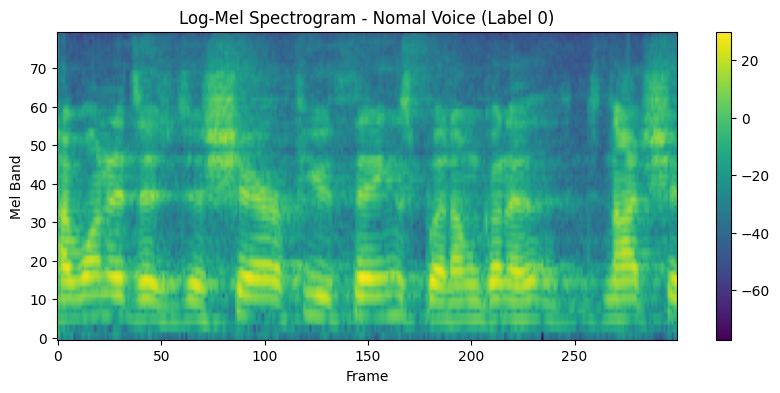

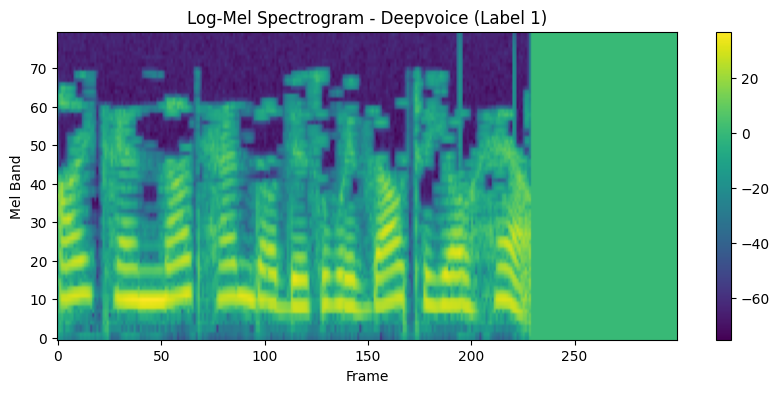

In [ ]:

# 경로 설정
label0_dir = "/content/drive/MyDrive/Capstone/label_0"
label1_dir = "/content/drive/MyDrive/Capstone/label_1"


# 첫 번째 .npy 파일 불러오기
first_normal_path = sorted(glob.glob(os.path.join(label0_dir, "*.npy")))[0]  # 라벨 0 중 첫 샘플 경로
first_fake_path = sorted(glob.glob(os.path.join(label1_dir, "*.npy")))[0]    # 라벨 1 중 첫 샘플 경로
'''
# 모든 .npy 파일 리스트 수집
label0_files = glob.glob(os.path.join(label0_dir, "*.npy"))
label1_files = glob.glob(os.path.join(label1_dir, "*.npy"))

# 랜덤 샘플 선택
random_normal_path = random.choice(label0_files)
random_fake_path = random.choice(label1_files)
'''

# numpy 배열 로드
first_normal = np.load(first_normal_path)  # (80, 500) 형태의 Mel-spectrogram
first_fake = np.load(first_fake_path)

# 시각화 함수 정의
def plot_spectrogram(feature, title):
    plt.figure(figsize=(10, 4))                            # 그래프 크기 설정
    plt.imshow(feature, origin="lower", aspect="auto",    # Mel-spectrogram 이미지로 시각화
               cmap="viridis")                            # 색상 맵 설정
    plt.title(title)                                       # 그래프 제목
    plt.xlabel("Frame")                                    # x축 라벨 (시간축)
    plt.ylabel("Mel Band")                                 # y축 라벨 (주파수 밴드)
    plt.colorbar()                                         # 컬러 바 표시
    plt.show()                                             # 그래프 출력

# 라벨 0 (정상) 시각화
plot_spectrogram(
    first_normal,                                         # 로드한 Mel-spectrogram
    "Log-Mel Spectrogram - Nomal Voice (Label 0)"           # 제목
   # "Log-Mel Spectrogram - Random Nomal Sample\n{os.path.basename(random_normal_path)}"
)

# 라벨 1 (딥보이스) 시각화
plot_spectrogram(
    first_fake,
    "Log-Mel Spectrogram - Deepvoice (Label 1)"
    # "Log-Mel Spectrogram - Random Deepvoice Sample\n{os.path.basename(random_fake_path)}"
)

# 6.1 랜덤 출력

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

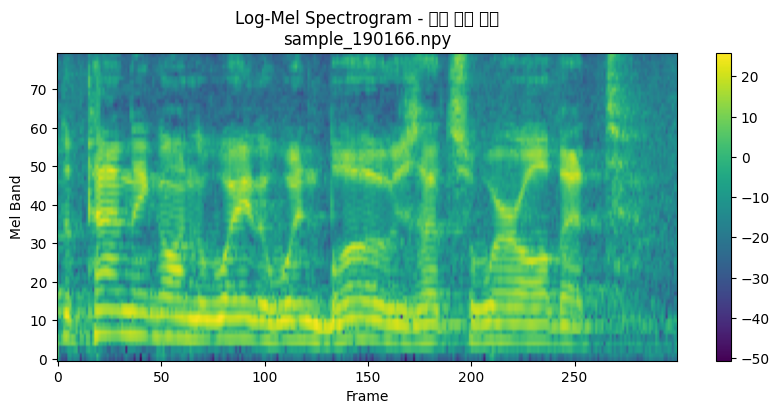

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46373 (\N{HANGUL SYLLABLE DIB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


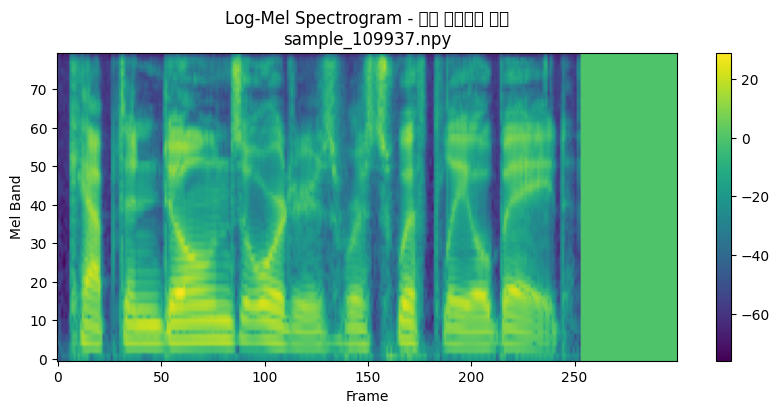

In [ ]:
import random  # 무작위 샘플 선택용

# 경로 설정
label0_dir = "/content/drive/MyDrive/Capstone/label_0"
label1_dir = "/content/drive/MyDrive/Capstone/label_1"

# 모든 .npy 파일 리스트 수집
label0_files = glob.glob(os.path.join(label0_dir, "*.npy"))
label1_files = glob.glob(os.path.join(label1_dir, "*.npy"))

# 랜덤 샘플 선택
random_normal_path = random.choice(label0_files)
random_fake_path = random.choice(label1_files)

# numpy 배열 로드
random_normal = np.load(random_normal_path)
random_fake = np.load(random_fake_path)

# 시각화 함수 정의
def plot_spectrogram(feature, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(feature, origin="lower", aspect="auto", cmap="viridis")
    plt.title(title)
    plt.xlabel("Frame")
    plt.ylabel("Mel Band")
    plt.colorbar()
    plt.show()

# 라벨 0 (정상 음성) 시각화
plot_spectrogram(
    random_normal,
    f"Log-Mel Spectrogram - 랜덤 정상 샘플\n{os.path.basename(random_normal_path)}"
)

# 라벨 1 (딥보이스 음성) 시각화
plot_spectrogram(
    random_fake,
    f"Log-Mel Spectrogram - 랜덤 딥보이스 샘플\n{os.path.basename(random_fake_path)}"
)
